In [1]:
!pip install git+https://github.com/jlumbroso/python-random-hash.git

  Cloning https://github.com/jlumbroso/python-random-hash.git to /tmp/pip-req-build-p6cw115t
  Running command git clone --filter=blob:none --quiet https://github.com/jlumbroso/python-random-hash.git /tmp/pip-req-build-p6cw115t
  Resolved https://github.com/jlumbroso/python-random-hash.git to commit 327f6de9f7566e3dddf92af22d18f0cbed6d610c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for randomhash: filename=randomhash-0.6.0-py3-none-any.whl size=9745 sha256=735a45478cfc86a2b13568786c0e391706a9c6cc531b2fe1dd9b3501f87f9840
  Stored in directory: /tmp/pip-ephem-wheel-cache-qdnnbfn3/wheels/fe/14/2c/5dde7a9ad8e6b195acb80a8bd927bd72684b9e15e8272ce4a1
Successfully built randomhash


In [16]:
import numpy as np
import math
import random
import randomhash
import matplotlib.pyplot as plt

In [3]:
class HashManager:
    def __init__(self, count=1):
        self.family = randomhash.RandomHashFamily(count=count)

    def get_hash(self, item, index=0):
        item_str = str(item)
        return self.family.hashes(item_str)[index]

In [4]:
global_hasher = HashManager(count=100)

In [5]:
class HyperLogLog:
    def __init__(self, b, hash_index=0):
        self.b = b  # number of bit for the bucket index
        self.m = 1 << b  # number of buckets (2^b)
        self.registers = [0] * self.m # maximum number of leading zeros seen in every bucket
        self.hash_index = hash_index

        # Define alpha
        if self.m == 16:
            self.alpha_m = 0.673
        elif self.m == 32:
            self.alpha_m = 0.697
        elif self.m == 64:
            self.alpha_m = 0.709
        else:
            self.alpha_m = 0.7213 / (1 + 1.079 / self.m)

    # Counting Leading Zeros
    def _clz(self, x, width=32):
        if x == 0: return width + 1
        binary = bin(x)[2:].zfill(width)
        return len(binary) - len(binary.lstrip('0')) + 1

    # Adding a new word
    def add(self, item):
        x = global_hasher.get_hash(item, self.hash_index)
        x = x & 0xFFFFFFFF  # Ensure 32-bit
        j = x & (self.m - 1)  # index of the bucket it belongs
        w = x >> self.b # Remove the bits used for the bucket
        rho = self._clz(w, width=(32 - self.b)) # Rank
        self.registers[j] = max(self.registers[j], rho) # Update if necesarry

    def count(self):
        Z = sum([2.0**(-reg) for reg in self.registers])
        E = self.alpha_m * (self.m ** 2) / Z
        if E <= 2.5 * self.m:
            V = self.registers.count(0) # Number of empty buckets
            if V > 0:
                E = self.m * math.log(self.m / V)
        return int(E)

In [6]:
class Recordinality:
    def __init__(self, k, hash_index=0):
        self.k = k
        self.current_k_set = set()
        self.R = 0
        self.hash_index = hash_index

    def add(self, item):
        h = global_hasher.get_hash(item, self.hash_index)

        if len(self.current_k_set) < self.k:
            if h not in self.current_k_set:
                self.current_k_set.add(h)
                self.R += 1

        else:
            current_min = min(self.current_k_set)
            if h > current_min and h not in self.current_k_set:
                self.current_k_set.remove(current_min) # Remove smallest
                self.current_k_set.add(h)              # Add the new large value
                self.R += 1                            # Increment Record counter

    def count(self):
        exponent = self.R - self.k + 1
        estimated_n = self.k * ((1 + 1.0/self.k) ** exponent) - 1
        return int(estimated_n)

In [7]:
def generate_zipf_stream(N, n, alpha):
    distinct_elements = np.arange(1, n + 1)
    if alpha == 0:
        probs = np.ones(n) / n
    else:
        weights = 1.0 / (distinct_elements ** alpha)
        probs = weights / np.sum(weights)
    return np.random.choice(distinct_elements, size=N, p=probs)

In [8]:
def run_test():
    print("--- Running Synthetic Test with randomhash ---")
    N, n, alpha = 100000, 5000, 1.0
    stream = generate_zipf_stream(N, n, alpha)

    # Run HLL and REC using the first hash function (index 0)
    hll = HyperLogLog(b=10, hash_index=0)
    rec = Recordinality(k=128, hash_index=0)

    for item in stream:
        hll.add(item)
        rec.add(item)

    print(f"True Cardinality: {n}")
    print(f"HLL Estimate:     {hll.count()}")
    print(f"REC Estimate:     {rec.count()}")

In [9]:
run_test()

--- Running Synthetic Test with randomhash ---
True Cardinality: 5000
HLL Estimate:     5324
REC Estimate:     6720


In [10]:
def get_true_cardinality(dat_filename):
    """
    Reads the .dat file to find the true number of unique elements.
    Each line in the .dat file represents one unique word.
    """
    try:
        with open(dat_filename, 'r', encoding='utf-8', errors='ignore') as f:
            return len(f.readlines())
    except FileNotFoundError:
        print(f"Error: {dat_filename} not found.")
        return 0

In [12]:
def run_main_comparison(txt_filename, dat_filename, trials=10):
    print(f"--- Processing {txt_filename} ---")

    # 1. Load Data
    true_n = get_true_cardinality(dat_filename)
    with open(txt_filename, 'r', encoding='utf-8', errors='ignore') as f:
        stream = f.read().split()

    print(f"Stream Length: {len(stream)}")
    print(f"True Cardinality: {true_n}")

    hll_estimates = []
    rec_estimates = []

    # 2. Run Trials
    # Note: We use the global 'global_hasher' defined earlier
    for i in range(trials):
        # HLL with b=10 (m=1024 registers)
        hll = HyperLogLog(b=10, hash_index=i)
        # REC with k=128 (keep 128 items)
        rec = Recordinality(k=128, hash_index=i)

        for item in stream:
            hll.add(item)
            rec.add(item)

        hll_estimates.append(hll.count())
        rec_estimates.append(rec.count())

    # 3. Print Results
    avg_hll = np.mean(hll_estimates)
    avg_rec = np.mean(rec_estimates)
    std_hll = np.std(hll_estimates)
    std_rec = np.std(rec_estimates)

    print("\n" + "="*60)
    print(f"{'Algorithm':<15} | {'Mean Est.':<12} | {'Std Dev':<10} | {'Rel Error %':<12}")
    print("-" * 60)

    err_hll = abs(avg_hll - true_n) / true_n * 100
    print(f"{'HyperLogLog':<15} | {avg_hll:<12.1f} | {std_hll:<10.1f} | {err_hll:<12.2f}%")

    err_rec = abs(avg_rec - true_n) / true_n * 100
    print(f"{'Recordinality':<15} | {avg_rec:<12.1f} | {std_rec:<10.1f} | {err_rec:<12.2f}%")
    print("="*60 + "\n")

In [13]:
def plot_memory_impact(txt_filename, dat_filename):
    print("--- Running Memory Impact Study ---")
    true_n = get_true_cardinality(dat_filename)

    with open(txt_filename, 'r', encoding='utf-8', errors='ignore') as f:
        stream = f.read().split()

    # A. HyperLogLog: Vary 'b' (which changes m = 2^b)
    # Testing b from 4 (16 registers) to 14 (16384 registers)
    b_values = range(4, 15)
    hll_errors = []

    for b in b_values:
        # Run 5 trials per b to get a stable average
        temp_errors = []
        for i in range(5):
            hll = HyperLogLog(b=b, hash_index=i)
            for item in stream: hll.add(item)
            # Calculate Relative Error
            err = abs(hll.count() - true_n) / true_n
            temp_errors.append(err)
        hll_errors.append(np.mean(temp_errors))

    # B. Recordinality: Vary 'k'
    # Testing k from 16 to 1024
    k_values = [16, 32, 64, 128, 256, 512, 1024]
    rec_errors = []

    for k in k_values:
        temp_errors = []
        for i in range(5):
            rec = Recordinality(k=k, hash_index=i)
            for item in stream: rec.add(item)
            err = abs(rec.count() - true_n) / true_n
            temp_errors.append(err)
        rec_errors.append(np.mean(temp_errors))

    # C. Plotting
    plt.figure(figsize=(12, 5))

    # Plot HLL
    plt.subplot(1, 2, 1)
    m_values = [2**b for b in b_values]
    plt.loglog(m_values, hll_errors, marker='o', label='HLL Error')
    plt.plot(m_values, [1.04/np.sqrt(m) for m in m_values], '--', label='Theoretical 1.04/sqrt(m)')
    plt.xlabel('Number of Registers (m)')
    plt.ylabel('Relative Error')
    plt.title('HLL: Memory vs Error')
    plt.grid(True, which="both", ls="-")
    plt.legend()

    # Plot REC
    plt.subplot(1, 2, 2)
    plt.loglog(k_values, rec_errors, marker='s', color='orange', label='REC Error')
    # Theoretical error for REC is roughly ~ 1/sqrt(k) (ignoring constants)
    plt.plot(k_values, [1.0/np.sqrt(k) for k in k_values], '--', color='red', label='Theoretical ~1/sqrt(k)')
    plt.xlabel('Number of Records (k)')
    plt.ylabel('Relative Error')
    plt.title('Recordinality: Memory vs Error')
    plt.grid(True, which="both", ls="-")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
run_main_comparison('dracula.txt', 'dracula.dat')

--- Processing dracula.txt ---
Stream Length: 124249
True Cardinality: 9425

Algorithm       | Mean Est.    | Std Dev    | Rel Error % 
------------------------------------------------------------
HyperLogLog     | 9294.5       | 298.4      | 1.38        %
Recordinality   | 7947.6       | 977.5      | 15.68       %



--- Running Memory Impact Study ---


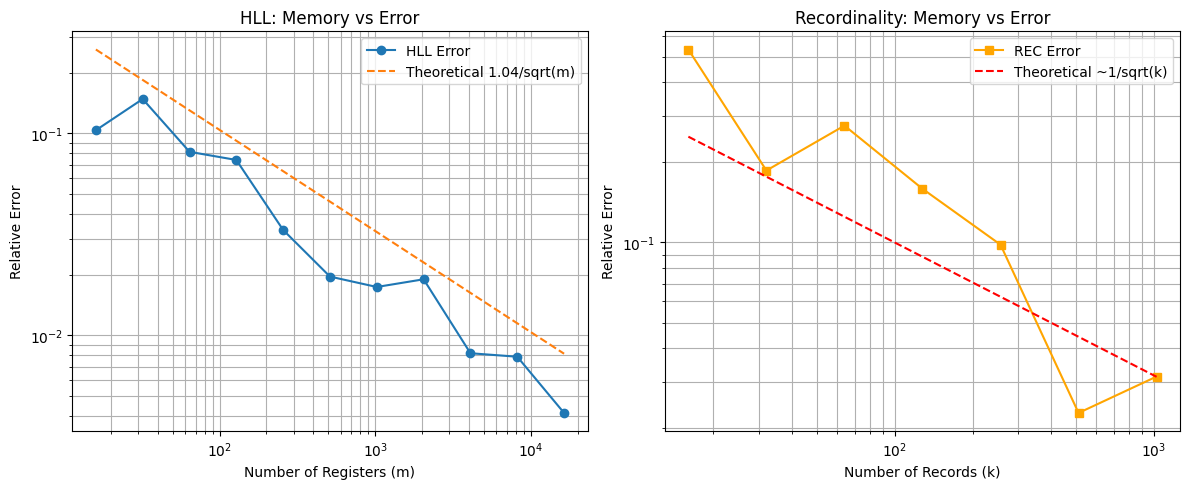

In [17]:
plot_memory_impact('dracula.txt', 'dracula.dat')